# Analysis after LDA topic modeling

This notebook is to visualize the impact of AI across industries, jobs, and technologies using various types of plots, distributions, timelines and correlations. The goal is to translate the enriched dataset into visuals for insights.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import re
from collections import Counter, defaultdict
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
np.random.seed(42)

In [3]:
# Cache directory
cache_dir = "cache"
os.makedirs(cache_dir, exist_ok=True)
print(f"Using cache directory: {os.path.abspath(cache_dir)}")

def get_cache_path(filename):
    """Get full path for a cache file"""
    return os.path.join(cache_dir, filename)

def save_to_cache(obj, filename):
    """Save object to cache"""
    with open(get_cache_path(filename), 'wb') as f:
        pickle.dump(obj, f)
    print(f"Saved {filename} to cache")

def load_from_cache(filename):
    """Load object from cache if it exists"""
    cache_path = get_cache_path(filename)
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    return None

Using cache directory: /Users/casey/Documents/GitHub/AI_impact_employment/cache


In [4]:
# To analyze the impact of AI on different industries and job categories.
def analyze_industry_job_impact(df):
    print("Analyzing industry and job impact...")
    
    # Dictionary to store the results
    impact_data = {
        'industries': {},
        'jobs': {}
    }
    
    # Checking if we have the industry and job data
    if 'detected_industries' not in df.columns or 'detected_jobs' not in df.columns:
        print("WARNING: Industry and job detection data not available. Skip this analysis.")
        return impact_data
    
    # Extracting the industries
    all_industries = []
    for ind_list in df['detected_industries'].dropna():
        if isinstance(ind_list, list) and ind_list:
            all_industries.extend(ind_list)
    
    # Extracting jobs
    all_jobs = []
    for job_list in df['detected_jobs'].dropna():
        if isinstance(job_list, list) and job_list:
            all_jobs.extend(job_list)
    
    # Counting the industries and jobs
    industry_counts = Counter(all_industries)
    job_counts = Counter(all_jobs)
    
    # Top industries and jobs
    top_industries = [ind for ind, count in industry_counts.most_common(10)]
    top_jobs = [job for job, count in job_counts.most_common(10)]
    
    # Calculating the sentiment by industry
    if 'sentiment_overall' in df.columns:
        # Industry sentiment
        industry_sentiment = {}
        for industry in top_industries:
            industry_articles = df[df['detected_industries'].apply(
                lambda x: isinstance(x, list) and industry in x
            )]
            if not industry_articles.empty:
                industry_sentiment[industry] = industry_articles['sentiment_overall'].mean()
        
        # Job sentiment
        job_sentiment = {}
        for job in top_jobs:
            job_articles = df[df['detected_jobs'].apply(
                lambda x: isinstance(x, list) and job in x
            )]
            if not job_articles.empty:
                job_sentiment[job] = job_articles['sentiment_overall'].mean()
        
        # Results
        impact_data['industries'] = {
            'counts': industry_counts,
            'sentiment': industry_sentiment
        }
        
        impact_data['jobs'] = {
            'counts': job_counts,
            'sentiment': job_sentiment
        }
    
    return impact_data

# To analyze the adoption and mention patterns of AI technologies.
def analyze_technology_adoption(df):
    print("Analyzing technology adoption...")
    
    tech_data = {
        'technology_mentions': {},
        'technology_trends': {},
        'models': {}
    }
    
    # Checking if we have technology data
    if 'ai_technologies' not in df.columns:
        print("WARNING: AI technology data not available. Skip this analysis.")
        return tech_data
    
    # Extracting all the technology mentions
    tech_categories = defaultdict(int)
    tech_mentions = defaultdict(list)
    model_mentions = defaultdict(int)
    
    for _, row in df.iterrows():
        techs = row.get('ai_technologies', {})
        if not techs:
            continue
        
        date = row['date']
        
        for tech_category, tech_items in techs.items():
            tech_categories[tech_category] += 1
            
            if isinstance(tech_items, list):
                for tech in tech_items:
                    tech_mentions[tech].append(date)
                    
                    # If this is a model name
                    if tech_category == 'specific_models':
                        model_mentions[tech] += 1
            else:
                tech_mentions[str(tech_items)].append(date)
    
    # Top technologies by category
    tech_data['technology_mentions'] = {
        'categories': dict(tech_categories),
        'models': dict(model_mentions)
    }
    
    # Technology trend by year and month
    tech_trends = {}
    for tech, dates in tech_mentions.items():
        if len(dates) < 5:  # Skip technologies with few mentions
            continue
            
        # Grouping by year and month
        date_counts = defaultdict(int)
        for date in dates:
            yearmonth = date.strftime('%Y-%m')
            date_counts[yearmonth] += 1
        
        # Timeseries
        if date_counts:
            tech_trends[tech] = dict(date_counts)
    
    tech_data['technology_trends'] = tech_trends
    
    return tech_data

# I created a network graph to visualize how different AI technologies relate to job categories. The graph uses nodes for both technologies and jobs and edges represent co-occurrences.
# I limited the graph to the top 50 most frequent pairs to keep it readable. I used networkx to draw the graph and added color nodes: blue for tech and green for jobs.
def create_tech_job_impact_network(df):
    print("Creating technology-job impact network...")
    
    # Checking if I have the required data
    if 'detected_jobs' not in df.columns or 'ai_technologies' not in df.columns:
        return plt.figure()
    
    # Networkx for network visualization
    import networkx as nx
    
    G = nx.Graph()
    
    # Extracting the technology and job co-occurrences
    tech_job_edges = []
    
    for _, row in df.iterrows():
        if isinstance(row.get('detected_jobs'), list) and isinstance(row.get('ai_technologies'), dict):
            jobs = row['detected_jobs']
            techs = list(row['ai_technologies'].keys())
            
            if jobs and techs:
                for job in jobs:
                    for tech in techs:
                        tech_job_edges.append((tech, job))
    
    # Counting the edge frequencies
    from collections import Counter
    edge_counts = Counter(tech_job_edges)
    
    # Nodes and edges on the graph
    for (tech, job), weight in edge_counts.most_common(50):  # Limit to top 50 relationships
        if tech not in G:
            G.add_node(tech, type='technology')
        if job not in G:
            G.add_node(job, type='job')
        G.add_edge(tech, job, weight=weight)
    
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    
    fig = plt.figure(figsize=(16, 12))
    
    # Node types
    tech_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'technology']
    job_nodes = [node for node, attr in G.nodes(data=True) if attr.get('type') == 'job']
    
    # Edge weights
    edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]
    
    # Edges
    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4, edge_color='gray')
    
    # Nodes with different colors for technologies and jobs
    nx.draw_networkx_nodes(G, pos, nodelist=tech_nodes, node_size=300, 
                          node_color='lightblue', alpha=0.8, edgecolors='blue')
    nx.draw_networkx_nodes(G, pos, nodelist=job_nodes, node_size=300, 
                          node_color='lightgreen', alpha=0.8, edgecolors='green')
    
    # Labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
    
    plt.title('AI Technology Impact on Job Categories Network', fontsize=16)
    
    # Adding the custom legend
    tech_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', 
                           markersize=15, label='AI Technology')
    job_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', 
                          markersize=15, label='Job Category')
    plt.legend(handles=[tech_patch, job_patch], loc='upper right')
    
    plt.axis('off')
    plt.tight_layout()
    
    return fig

# I used a violin plot to show the distribution of the sentiment scores for each industry, to compare how sentiment varies by industry in terms of AI discussion.
# I only included industries with at least 5 data to ensure reliability with colors green for positive sentiment, red for negative and orange for a neutral sentiment.
def create_industry_sentiment_distribution(df):
    print("Creating industry sentiment distribution...")
    
    # Checking if I have the required data
    if 'detected_industries' not in df.columns or 'sentiment_overall' not in df.columns:
        return plt.figure()
    
    # Industry sentiments
    industry_sentiments = {}
    
    for _, row in df.iterrows():
        if isinstance(row.get('detected_industries'), list) and pd.notnull(row.get('sentiment_overall')):
            for industry in row['detected_industries']:
                if industry not in industry_sentiments:
                    industry_sentiments[industry] = []
                industry_sentiments[industry].append(row['sentiment_overall'])
    
    # Filtering to keep industries with enough data
    filtered_industries = {k: v for k, v in industry_sentiments.items() if len(v) >= 5}
    
    if not filtered_industries:
        return plt.figure()
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Violin plots for each industry
    industries = list(filtered_industries.keys())
    data = [filtered_industries[ind] for ind in industries]
    
    # Mean sentiment
    mean_sentiments = [np.mean(values) for values in data]
    
    # Sorting industries by the mean sentiment
    sorted_indices = np.argsort(mean_sentiments)
    sorted_industries = [industries[i] for i in sorted_indices]
    sorted_data = [data[i] for i in sorted_indices]
    
    parts = ax.violinplot(sorted_data, vert=False, widths=0.8,
                          showmeans=True, showextrema=True, showmedians=True)
    
    # Colors based on the sentiment
    for i, pc in enumerate(parts['bodies']):
        mean_sentiment = np.mean(sorted_data[i])
        if mean_sentiment > 0.1:
            color = 'green'
        elif mean_sentiment < -0.1:
            color = 'red'
        else:
            color = 'orange'
            
        pc.set_facecolor(color)
        pc.set_alpha(0.7)
    
    ax.set_yticks(np.arange(1, len(sorted_industries) + 1))
    ax.set_yticklabels(sorted_industries)
    
    ax.set_title('Industry Sentiment Distribution', fontsize=16)
    ax.set_xlabel('Sentiment Score (-1 to 1)', fontsize=14)
    ax.set_ylabel('Industry', fontsize=14)
    
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    return fig

# I created a bar chart showing the most mentioned AI technologies by counting keyword mentions in the ai_technologies column.
# The chart shows which AI tools are most frequently discussed in the articles.
def create_technology_distribution(df):
    print("Creating technology distribution...")
    
    if 'ai_technologies' not in df.columns:
        return plt.figure()
    
    # Technology mentions
    tech_mentions = {}
    
    for _, row in df.iterrows():
        if isinstance(row.get('ai_technologies'), dict):
            for tech_category, techs in row['ai_technologies'].items():
                if isinstance(techs, list):
                    for tech in techs:
                        if tech not in tech_mentions:
                            tech_mentions[tech] = 0
                        tech_mentions[tech] += 1
                elif isinstance(techs, (int, float)):
                    if tech_category not in tech_mentions:
                        tech_mentions[tech_category] = 0
                    tech_mentions[tech_category] += 1
    
    # Top technologies
    top_techs = dict(sorted(tech_mentions.items(), key=lambda x: x[1], reverse=True)[:20])
    
    if not top_techs:
        return plt.figure()
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Bar chart
    bars = ax.barh(
        list(top_techs.keys()),
        list(top_techs.values()),
        height=0.7,
        color=plt.cm.viridis(np.linspace(0, 0.8, len(top_techs))),
        alpha=0.8,
        edgecolor='white',
        linewidth=0.5
    )
    
    for bar in bars:
        width = bar.get_width()
        label_position = width + (width * 0.02)
        ax.text(label_position, bar.get_y() + bar.get_height()/2, 
                f'{int(width)}', va='center', fontweight='bold')
    
    ax.set_title('AI Technology Mention Distribution', fontsize=16)
    ax.set_xlabel('Number of Mentions', fontsize=14)
    ax.set_ylabel('Technology', fontsize=14)
    
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    
    return fig

# I created a monthly sentiment timeline, I also added a breakdown by topic to track sentiment trends within specific areas.
# I marked key AI-related events to show how they influenced sentiment.
def analyze_sentiment_timeline(df):
    print("Analyzing sentiment timeline...")
    
    sentiment_data = {
        'timeline': {},
        'by_topic': {},
        'key_events': []
    }
    
    # Getting the sentiment data
    if 'sentiment_overall' not in df.columns and 'sentiment_base' not in df.columns:
        print("WARNING: Sentiment data not available. Skip this analysis.")
        return sentiment_data
    
    sentiment_col = 'sentiment_overall' if 'sentiment_overall' in df.columns else 'sentiment_base'
    
    # Timeline by month
    df['yearmonth'] = df['date'].dt.strftime('%Y-%m')
    monthly_sentiment = df.groupby('yearmonth')[sentiment_col].mean().reset_index()
    monthly_sentiment['date'] = pd.to_datetime(monthly_sentiment['yearmonth'] + '-01')
    monthly_sentiment = monthly_sentiment.sort_values('date')
    
    # Monthly sentiment
    sentiment_data['timeline'] = {
        'dates': monthly_sentiment['date'].dt.strftime('%Y-%m').tolist(),
        'values': monthly_sentiment[sentiment_col].tolist()
    }
    
    # Sentiment by topic
    if 'topic' in df.columns:
        topic_sentiment = {}
        for topic in df['topic'].unique():
            topic_data = df[df['topic'] == topic]
            topic_monthly = topic_data.groupby('yearmonth')[sentiment_col].mean().reset_index()
            topic_monthly['date'] = pd.to_datetime(topic_monthly['yearmonth'] + '-01')
            topic_monthly = topic_monthly.sort_values('date')
            
            topic_sentiment[int(topic)] = {
                'dates': topic_monthly['date'].dt.strftime('%Y-%m').tolist(),
                'values': topic_monthly[sentiment_col].tolist()
            }
        
        sentiment_data['by_topic'] = topic_sentiment
    
    # Key AI events
    key_events = [
        {'date': '2022-11', 'event': 'ChatGPT Release', 'impact': 0.1},
        {'date': '2023-03', 'event': 'GPT-4 Release', 'impact': 0.15},
        {'date': '2023-07', 'event': 'EU AI Act', 'impact': -0.05},
        {'date': '2023-10', 'event': 'Biden AI Executive Order', 'impact': 0.0},
        {'date': '2024-03', 'event': 'GPT-4o Release', 'impact': 0.12}
    ]
    
    sentiment_data['key_events'] = key_events
    
    return sentiment_data

# The function analyzes the relationships between the topics over time. I used one-hot encoding to track each topic's monthly occurrence.
# Then I calculated the correlation matrix to see which topics relate together. I also created topic labels using each topics top 3 keywords.
def analyze_topic_relationships(df, topic_terms):
    print("Analyzing topic relationships...")
    
    relationship_data = {
        'correlation': {},
        'topic_labels': {}
    }
    
    if 'topic' not in df.columns:
        print("WARNING: Topic assignment data not available. Skip this analysis.")
        return relationship_data
    
    # Topic labels
    topic_labels = {}
    for i, terms in enumerate(topic_terms):
        label = ', '.join(terms[:3])
        topic_labels[i] = f"Topic {i}: {label}"
    
    relationship_data['topic_labels'] = topic_labels
    
    # Topic matrix with the article and topic assignment
    topic_dummies = pd.get_dummies(df['topic'], prefix='topic')
    
    # Correlation between topics based on co-occurrence in similar time periods
    df_with_dummies = pd.concat([df, topic_dummies], axis=1)
    topic_cols = topic_dummies.columns.tolist()
    
    # Group by month and summing topic occurrence
    monthly_topics = df_with_dummies.groupby('yearmonth')[topic_cols].sum()
    
    # Correlation between topics over time
    topic_correlation = monthly_topics.corr()
    
    corr_dict = {}
    for i in range(len(topic_correlation)):
        corr_dict[int(i)] = {}
        for j in range(len(topic_correlation)):
            corr_dict[int(i)][int(j)] = float(topic_correlation.iloc[i, j])
    
    relationship_data['correlation'] = corr_dict
    
    return relationship_data

# This function looks at how often companies like OpenAI and Google are mentioned.
# I also measured the sentiment toward each company and the technologies they are associated with. Which helps identify AI leaders and their influence.
def analyze_organizations(df):
    print("Analyzing organizations...")
    
    org_data = {
        'top_organizations': {},
        'organization_sentiment': {},
        'technology_association': {}
    }
    
    # Looking for the organization data
    if 'top_organizations' not in df.columns:
        print("WARNING: Organization data not available. Skip this analysis.")
        return org_data
    
    # Extracting all the organization mentions
    all_orgs = []
    for org_list in df['top_organizations'].dropna():
        if isinstance(org_list, list) and org_list:
            all_orgs.extend(org_list)
    
    # Counting the organizations
    org_counts = Counter(all_orgs)
    
    # Top organizations
    top_orgs = [org for org, count in org_counts.most_common(20)]
    
    org_data['top_organizations'] = {org: count for org, count in org_counts.most_common(20)}
    
    # Calculating the sentiment by organization
    if 'sentiment_overall' in df.columns:
        org_sentiment = {}
        for org in top_orgs:
            org_articles = df[df['top_organizations'].apply(
                lambda x: isinstance(x, list) and org in x
            )]
            if not org_articles.empty:
                org_sentiment[org] = float(org_articles['sentiment_overall'].mean())
        
        org_data['organization_sentiment'] = org_sentiment
    
    # Associating organizations with AI technologies
    if 'ai_technologies' in df.columns:
        org_tech = {}
        for org in top_orgs:
            org_articles = df[df['top_organizations'].apply(
                lambda x: isinstance(x, list) and org in x
            )]
            
            tech_mentions = defaultdict(int)
            for _, row in org_articles.iterrows():
                techs = row.get('ai_technologies', {})
                if not techs:
                    continue
                
                for tech_category in techs.keys():
                    tech_mentions[tech_category] += 1
            
            if tech_mentions:
                org_tech[org] = dict(tech_mentions)
        
        org_data['technology_association'] = org_tech
    
    return org_data

# This function compiles all charts into one dictionary. I added error handling to ensure that the function can still run
# even when some intermediate data is missing.
def create_enhanced_visualizations(df, analysis_results, topic_terms):
    print("Creating enhanced visualizations...")
    
    figures = {}
    
    # 1. Industry impact heatmap
    if 'industry_job_impact' in analysis_results and 'industries' in analysis_results['industry_job_impact'] and 'sentiment' in analysis_results['industry_job_impact']['industries']:
        figures['industry_heatmap'] = create_industry_impact_heatmap(df)
    
    # 2. Job impact analysis
    if 'industry_job_impact' in analysis_results and 'jobs' in analysis_results['industry_job_impact'] and 'sentiment' in analysis_results['industry_job_impact']['jobs']:
        # If you have the original job impact chart function
        try:
            figures['job_impact'] = create_job_impact_chart(
                analysis_results['industry_job_impact']['jobs'],
                analysis_results['industry_job_impact']['industries']
            )
        except (NameError, TypeError):
            print("Warning: Original job impact chart could not be created")
        
        # Creating separated charts with only job data
        separated_charts = create_job_impact_separated_charts(
            analysis_results['industry_job_impact']['jobs']
        )
        figures['enhanced_jobs'] = separated_charts['enhanced']
        figures['at_risk_jobs'] = separated_charts['at_risk']
    
    
    # 3. Technology adoption timeline
    if 'technology_adoption' in analysis_results and 'technology_trends' in analysis_results['technology_adoption']:
        figures['technology_timeline'] = create_technology_timeline(
            analysis_results['technology_adoption']['technology_trends']
        )
    
    # 4. Sentiment timeline with the events
    if 'sentiment_timeline' in analysis_results and 'timeline' in analysis_results['sentiment_timeline']:
        figures['sentiment_timeline'] = create_sentiment_timeline_with_events(
            analysis_results['sentiment_timeline']
        )
    
    # 5. Topic correlation heatmap
    if 'topic_relationships' in analysis_results and 'correlation' in analysis_results['topic_relationships']:
        figures['topic_correlation'] = create_topic_correlation_heatmap(
            analysis_results['topic_relationships']['correlation'],
            analysis_results['topic_relationships']['topic_labels']
        )
    
    # 6. Organization AI strategy comparison
    if 'organization_analysis' in analysis_results and 'organization_sentiment' in analysis_results['organization_analysis']:
        figures['org_strategy'] = create_organization_strategy_chart(
            analysis_results['organization_analysis']
        )
    
    # 7. AI technology job impact network
    figures['tech_job_network'] = create_tech_job_impact_network(df)
    
    # 8. Industry sentiment distribution
    figures['industry_sentiment_distribution'] = create_industry_sentiment_distribution(df)
    
    # 9. Technology distribution 
    figures['technology_distribution'] = create_technology_distribution(df)
    
    return figures

In [5]:
# Creates a heatmap showing the average sentiment for the top 10 industries over time.
def create_industry_impact_heatmap(df):
    if 'detected_industries' not in df.columns or 'sentiment_overall' not in df.columns:
        return plt.figure()
    
    # Creating one row per industry
    exploded_df = df.explode('detected_industries').dropna(subset=['detected_industries'])
    
    # Industry counts
    industry_counts = exploded_df['detected_industries'].value_counts()
    
    # Top industries
    top_industries = industry_counts.head(10).index.tolist()
    
    # Top industries
    industry_df = exploded_df[exploded_df['detected_industries'].isin(top_industries)]
    
    # Grouping by industry and year
    industry_df['year'] = industry_df['date'].dt.year
    industry_year_sentiment = industry_df.groupby(['detected_industries', 'year'])['sentiment_overall'].mean().reset_index()
    
    pivot_df = industry_year_sentiment.pivot(index='detected_industries', columns='year', values='sentiment_overall')
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df, annot=True, cmap='RdYlGn', center=0, fmt='.2f')
    plt.title('AI Impact Sentiment by Industry and Year')
    plt.ylabel('Industry')
    plt.xlabel('Year')
    plt.tight_layout()
    
    return plt.gcf()

# This function analyzes the impact of AI on different industries and job categories.
# It uses the sentiment data to identify which industries and jobs are most affected by AI.
def analyze_industry_job_impact(df):
    print("Analyzing industry and job impact...")
    
    # Dictionary for the analysis
    impact_data = {
        'industries': {},
        'jobs': {}
    }
    
    # Check ing if I have the industry and job data
    if 'detected_industries' not in df.columns or 'detected_jobs' not in df.columns:
        print("WARNING: Industry and job detection data not available. Skip this analysis.")
        return impact_data
    
    # Extracting the industries
    all_industries = []
    for ind_list in df['detected_industries'].dropna():
        if isinstance(ind_list, list) and ind_list:
            all_industries.extend(ind_list)
    
    # Extracting jobs
    all_jobs = []
    for job_list in df['detected_jobs'].dropna():
        if isinstance(job_list, list) and job_list:
            all_jobs.extend(job_list)
    
    # Counting industries and jobs
    from collections import Counter
    industry_counts = Counter(all_industries)
    job_counts = Counter(all_jobs)
    
    # Top industries and jobs
    top_industries = [ind for ind, count in industry_counts.most_common(10)]
    top_jobs = [job for job, count in job_counts.most_common(10)]
    
    # Sentiment by industry
    if 'sentiment_overall' in df.columns:
        industry_sentiment = {}
        for industry in top_industries:
            industry_articles = df[df['detected_industries'].apply(
                lambda x: isinstance(x, list) and industry in x
            )]
            if not industry_articles.empty:
                industry_sentiment[industry] = industry_articles['sentiment_overall'].mean()
        
        # Job sentiment
        job_sentiment = {}
        for job in top_jobs:
            job_articles = df[df['detected_jobs'].apply(
                lambda x: isinstance(x, list) and job in x
            )]
            if not job_articles.empty:
                job_sentiment[job] = job_articles['sentiment_overall'].mean()
    
        impact_data['industries'] = {
            'counts': industry_counts,
            'sentiment': industry_sentiment
        }
        
        impact_data['jobs'] = {
            'counts': job_counts,
            'sentiment': job_sentiment
        }
    
    return impact_data

# The function analyzes which industries have the most jobs at risk based on the sentiment analysis.
def analyze_industries_by_risk(df):
    print("Analyzing industries with jobs at risk...")
    
    if 'detected_industries' not in df.columns or 'detected_jobs' not in df.columns or 'sentiment_overall' not in df.columns:
        print("WARNING: Required data for industry risk analysis is missing")
        return {}
    
    industry_risk_data = {}
    
    # Analyzing each article 
    for _, row in df.iterrows():
        # Skip rows without the required data
        if not isinstance(row.get('detected_industries'), list) or not isinstance(row.get('detected_jobs'), list):
            continue
            
        # Sentiment
        sentiment = row.get('sentiment_overall', 0)
        
        # For each industry, if sentiment is negative and job categories are present,
        # it associates the negative sentiment with the industry
        if sentiment < 0 and row['detected_jobs']:
            for industry in row['detected_industries']:
                if industry not in industry_risk_data:
                    industry_risk_data[industry] = {
                        'negative_mentions': 0,
                        'total_mentions': 0,
                        'at_risk_jobs': set(),
                        'risk_score': 0
                    }
                
                industry_risk_data[industry]['negative_mentions'] += 1
                industry_risk_data[industry]['at_risk_jobs'].update(row['detected_jobs'])
        
        # Counting the total mentions of each industry regardless of sentiment
        for industry in row['detected_industries']:
            if industry not in industry_risk_data:
                industry_risk_data[industry] = {
                    'negative_mentions': 0,
                    'total_mentions': 0,
                    'at_risk_jobs': set(),
                    'risk_score': 0
                }
            industry_risk_data[industry]['total_mentions'] += 1
    
    # Calculating the risk score for each industry
    # Risk score = (negative_mentions / total_mentions) * number of at risk jobs
    for industry, data in industry_risk_data.items():
        if data['total_mentions'] > 0:
            negative_ratio = data['negative_mentions'] / data['total_mentions']
            data['risk_score'] = negative_ratio * len(data['at_risk_jobs'])
            data['at_risk_jobs'] = list(data['at_risk_jobs'])
    
    return industry_risk_data

# Printing the top industries with the highest number of jobs at risk from AI.
def print_top_at_risk_industries(industry_risk_data, top_n=10):
    # Sort industries by risk score
    sorted_industries = sorted(
        industry_risk_data.items(), 
        key=lambda x: x[1]['risk_score'], 
        reverse=True
    )
    
    print("\n" + "="*80)
    print(f"TOP {top_n} INDUSTRIES WITH JOBS AT RISK FROM AI")
    print("="*80)
    
    print(f"{'Rank':<5} {'Industry':<30} {'Risk Score':<12} {'Neg. Mentions':<15} {'Total Mentions':<15} {'# Jobs at Risk':<15}")
    print("-"*80)
    
    for i, (industry, data) in enumerate(sorted_industries[:top_n], 1):
        print(f"{i:<5} {industry[:30]:<30} {data['risk_score']:.4f}       {data['negative_mentions']:<15} {data['total_mentions']:<15} {len(data['at_risk_jobs']):<15}")
    
    # Specific jobs at risk
    if sorted_industries:
        top_industry, top_data = sorted_industries[0]
        print("\nJobs at risk in the top industry - " + top_industry + ":")
        for job in sorted(top_data['at_risk_jobs']):
            print(f"- {job}")
    
    print("\n")

# The top industries with jobs at risk from AI.
def visualize_at_risk_industries(industry_risk_data, top_n=10):
    # Sorting the industries by risk score
    sorted_industries = sorted(
        industry_risk_data.items(), 
        key=lambda x: x[1]['risk_score'], 
        reverse=True
    )[:top_n]
    
    if not sorted_industries:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, "No risk data available", ha='center', va='center', fontsize=14)
        ax.set_title('Industries with Most Jobs at Risk from AI', fontsize=16)
        return fig
    
    # Extracting the data
    industries = [item[0] for item in sorted_industries]
    risk_scores = [item[1]['risk_score'] for item in sorted_industries]
    job_counts = [len(item[1]['at_risk_jobs']) for item in sorted_industries]
    neg_ratios = [item[1]['negative_mentions']/item[1]['total_mentions'] if item[1]['total_mentions'] > 0 else 0 
                 for item in sorted_industries]
    
    fig, ax = plt.subplots(figsize=(14, 10))
    
    bars = ax.barh(
        industries,
        risk_scores,
        height=0.6,
        color=plt.cm.Reds(np.array(neg_ratios)),
        alpha=0.8,
        edgecolor='darkred',
        linewidth=0.5
    )
    
    # Count labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_position = width + (width * 0.02)
        ax.text(label_position, bar.get_y() + bar.get_height()/2, 
                f'Jobs at risk: {job_counts[i]}', va='center', fontweight='bold')
    
    ax.set_title('Industries with Most Jobs at Risk from AI', fontsize=16, fontweight='bold')
    ax.set_xlabel('Risk Score (Negative Sentiment Ratio × Jobs Affected)', fontsize=14)
    ax.set_ylabel('Industry', fontsize=14)
    
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    
    # Color bar for negative sentiment ratio
    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(0, 1))
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Negative Sentiment Ratio', rotation=270, labelpad=20)
    
    plt.tight_layout()
    
    return fig


# This function creates a heatmap showing which jobs are at risk in which industries.
def visualize_industry_job_risk_heatmap(industry_risk_data, top_n=10):
    # Sorting the industries by risk score
    sorted_industries = sorted(
        industry_risk_data.items(), 
        key=lambda x: x[1]['risk_score'], 
        reverse=True
    )[:top_n]
    
    # Top industries
    top_industries = [item[0] for item in sorted_industries]
    
    # Collecting all the unique jobs at risk across the industries
    all_jobs = set()
    for _, data in sorted_industries:
        all_jobs.update(data['at_risk_jobs'])
    all_jobs = sorted(all_jobs)
    
    matrix = np.zeros((len(all_jobs), len(top_industries)))
    
    for j, (industry, data) in enumerate(sorted_industries):
        for i, job in enumerate(all_jobs):
            if job in data['at_risk_jobs']:
                # Set the value to the industry's negative sentiment ratio
                matrix[i, j] = data['negative_mentions'] / data['total_mentions'] if data['total_mentions'] > 0 else 0
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Heatmap
    im = ax.imshow(matrix, cmap='YlOrRd')
    
    ax.set_xticks(range(len(top_industries)))
    ax.set_yticks(range(len(all_jobs)))
    ax.set_xticklabels(top_industries, rotation=45, ha="right")
    ax.set_yticklabels(all_jobs)
    
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Negative Sentiment Ratio", rotation=-90, va="bottom")
    
    ax.set_title("Jobs at Risk by Industry", fontsize=16, fontweight='bold')
    
    ax.set_xticks(np.arange(-.5, len(top_industries), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(all_jobs), 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=1, alpha=0.2)
    
    plt.tight_layout()
    
    return fig

# Separate charts for jobs enhanced vs at risk from AI.
def create_job_impact_separated_charts(job_data):
    if not job_data.get('sentiment'):
        return {'enhanced': plt.figure(), 'at_risk': plt.figure()}
    
    enhanced_jobs = []
    at_risk_jobs = []
    
    for job, sentiment in job_data['sentiment'].items():
        mention_count = job_data['counts'][job]
        
        # Categorizing based on the sentiment
        if sentiment > 0:
            enhanced_jobs.append({
                'job_category': job,
                'sentiment_score': sentiment,
                'mention_count': mention_count,
                'impact_score': abs(sentiment) * mention_count / 100  
            })
        else:
            at_risk_jobs.append({
                'job_category': job,
                'sentiment_score': sentiment,
                'mention_count': mention_count,
                'impact_score': abs(sentiment) * mention_count / 100  
            })
    
    # Sorting by impact
    enhanced_jobs = sorted(enhanced_jobs, key=lambda x: x['impact_score'])
    at_risk_jobs = sorted(at_risk_jobs, key=lambda x: x['impact_score'])
    
    fig_enhanced = plt.figure(figsize=(12, 8))
    ax_enhanced = fig_enhanced.add_subplot(111)
    
    # Plotting jobs
    bars_enhanced = ax_enhanced.barh(
        [job['job_category'] for job in enhanced_jobs],
        [job['impact_score'] for job in enhanced_jobs],
        height=0.7,
        color='green',
        alpha=0.7
    )
    
    ax_enhanced.set_title('Jobs Enhanced by AI Technologies', fontsize=16)
    ax_enhanced.set_xlabel('Impact Score (Sentiment × Mention Frequency)', fontsize=12)
    ax_enhanced.set_ylabel('Job Category', fontsize=12)
    ax_enhanced.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    # At risk jobs figure
    fig_at_risk = plt.figure(figsize=(12, 8))
    ax_at_risk = fig_at_risk.add_subplot(111)
    
    bars_at_risk = ax_at_risk.barh(
        [job['job_category'] for job in at_risk_jobs],
        [job['impact_score'] for job in at_risk_jobs],
        height=0.7,
        color='red',
        alpha=0.7
    )
    
    ax_at_risk.set_title('Jobs At Risk from AI Technologies', fontsize=16)
    ax_at_risk.set_xlabel('Impact Score (Sentiment × Mention Frequency)', fontsize=12)
    ax_at_risk.set_ylabel('Job Category', fontsize=12)
    ax_at_risk.grid(axis='x', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    return {'enhanced': fig_enhanced, 'at_risk': fig_at_risk}

# This function creates a timeline showing the adoption or mention of AI technologies over time.
def create_technology_timeline(tech_trends):
    if not tech_trends:
        return plt.figure()
    
    data_rows = []
    for tech, yearmonth_counts in tech_trends.items():
        for yearmonth, count in yearmonth_counts.items():
            data_rows.append({
                'technology': tech,
                'yearmonth': yearmonth,
                'count': count
            })
    
    tech_df = pd.DataFrame(data_rows)
    
    # Top technologies by total mentions
    tech_totals = tech_df.groupby('technology')['count'].sum().sort_values(ascending=False)
    top_techs = tech_totals.head(5).index.tolist()
    
    tech_df = tech_df[tech_df['technology'].isin(top_techs)]
    
    # Converting to datetime
    tech_df['date'] = pd.to_datetime(tech_df['yearmonth'] + '-01')
    tech_df = tech_df.sort_values('date')
    
    plt.figure(figsize=(14, 7))
    
    for i, tech in enumerate(top_techs):
        tech_data = tech_df[tech_df['technology'] == tech]
        plt.plot(
            tech_data['date'], 
            tech_data['count'],
            marker='o',
            linestyle='-',
            linewidth=2,
            markersize=4,
            alpha=0.8,
            label=tech
        )
    
    plt.title('AI Technology Adoption Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Mentions', fontsize=14)
    plt.legend(title='Technology', loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

# It analyzes which AI technologies pose the most risk to jobs based on co-occurrence
def analyze_technologies_by_risk(df):
    print("Analyzing technologies by risk to jobs...")
    
    if 'ai_technologies' not in df.columns or 'detected_jobs' not in df.columns or 'sentiment_overall' not in df.columns:
        print("WARNING: Required data for technology risk analysis is missing")
        return {}
    
    # Dictionary for the analysis
    tech_risk_data = {}
    
    # Analyzing each article 
    for _, row in df.iterrows():
        if not isinstance(row.get('ai_technologies'), dict) or not isinstance(row.get('detected_jobs'), list):
            continue
            
        # Getting the sentiment
        sentiment = row.get('sentiment_overall', 0)
        
        # Extracting the technologies mentioned
        technologies = []
        for tech_category, tech_items in row['ai_technologies'].items():
            if isinstance(tech_items, list):
                technologies.extend(tech_items)
            else:
                technologies.append(tech_category)
        
        # For each technology, if the sentiment is negative and job categories are present I associate the negative sentiment with the technology.
        if sentiment < 0 and row['detected_jobs']:
            for tech in technologies:
                if tech not in tech_risk_data:
                    tech_risk_data[tech] = {
                        'negative_mentions': 0,
                        'total_mentions': 0,
                        'at_risk_jobs': set(),
                        'risk_score': 0
                    }
                
                tech_risk_data[tech]['negative_mentions'] += 1
                tech_risk_data[tech]['at_risk_jobs'].update(row['detected_jobs'])
        
        # Counting the total mentions of each technology regardless of the sentiment.
        for tech in technologies:
            if tech not in tech_risk_data:
                tech_risk_data[tech] = {
                    'negative_mentions': 0,
                    'total_mentions': 0,
                    'at_risk_jobs': set(),
                    'risk_score': 0
                }
            tech_risk_data[tech]['total_mentions'] += 1
    
    # Calculating the risk score for each technology
    # Risk score = (negative_mentions / total_mentions) * number of at risk jobs
    for tech, data in tech_risk_data.items():
        if data['total_mentions'] > 0:
            negative_ratio = data['negative_mentions'] / data['total_mentions']
            data['risk_score'] = negative_ratio * len(data['at_risk_jobs'])
            data['at_risk_jobs'] = list(data['at_risk_jobs'])
    
    return tech_risk_data

# The function prints the top technologies with the highest risk to jobs.
def print_top_at_risk_technologies(tech_risk_data, top_n=10):

    sorted_techs = sorted(
        tech_risk_data.items(), 
        key=lambda x: x[1]['risk_score'], 
        reverse=True
    )
    

    print("\n" + "="*80)
    print(f"TOP {top_n} TECHNOLOGIES POSING HIGHEST RISK TO JOBS")
    print("="*80)
    
    print(f"{'Rank':<5} {'Technology':<30} {'Risk Score':<12} {'Neg. Mentions':<15} {'Total Mentions':<15} {'# Jobs at Risk':<15}")
    print("-"*80)
    
    for i, (tech, data) in enumerate(sorted_techs[:top_n], 1):
        print(f"{i:<5} {tech[:30]:<30} {data['risk_score']:.4f}       {data['negative_mentions']:<15} {data['total_mentions']:<15} {len(data['at_risk_jobs']):<15}")
    
    print("\n")

# The function visualizes the top technologies posing the highest risk to jobs.
def visualize_at_risk_technologies(tech_risk_data, top_n=10):
    # Sorting the technologies by risk score
    sorted_techs = sorted(
        tech_risk_data.items(), 
        key=lambda x: x[1]['risk_score'], 
        reverse=True
    )[:top_n]
    

    if not sorted_techs:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, "No risk data available", ha='center', va='center', fontsize=14)
        ax.set_title('Top Technologies Posing Risk to Jobs', fontsize=16)
        return fig
    
    # Extracting the data
    techs = [item[0] for item in sorted_techs]
    risk_scores = [item[1]['risk_score'] for item in sorted_techs]
    job_counts = [len(item[1]['at_risk_jobs']) for item in sorted_techs]
    neg_ratios = [item[1]['negative_mentions']/item[1]['total_mentions'] if item[1]['total_mentions'] > 0 else 0 
                 for item in sorted_techs]
    

    fig, ax = plt.subplots(figsize=(14, 10))
    

    bars = ax.barh(
        techs,
        risk_scores,
        height=0.6,
        color=plt.cm.Reds(np.array(neg_ratios)),
        alpha=0.8,
        edgecolor='darkred',
        linewidth=0.5
    )
    

    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_position = width + (width * 0.02)
        ax.text(label_position, bar.get_y() + bar.get_height()/2, 
                f'Jobs at risk: {job_counts[i]}', va='center', fontweight='bold')
    

    ax.set_title('Top Technologies Posing Risk to Jobs', fontsize=16, fontweight='bold')
    ax.set_xlabel('Risk Score (Negative Sentiment Ratio × Jobs Affected)', fontsize=14)
    ax.set_ylabel('Technology', fontsize=14)
    

    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    

    sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(0, 1))
    sm.set_array([])
    

    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Negative Sentiment Ratio', rotation=270, labelpad=20)
    
    plt.tight_layout()
    
    return fig

# This function creates a timeline of sentiment with key events.
def create_sentiment_timeline_with_events(sentiment_data):
    if not sentiment_data.get('timeline', {}).get('dates'):
        return plt.figure()
    
    dates = [pd.to_datetime(date + '-01') for date in sentiment_data['timeline']['dates']]
    values = sentiment_data['timeline']['values']
    
    plt.figure(figsize=(15, 7))
    
    # Plotting the sentiment line
    plt.plot(dates, values, marker='o', linestyle='-', color='blue', alpha=0.7)
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Adding the event annotations
    for event in sentiment_data['key_events']:
        event_date = pd.to_datetime(event['date'] + '-01')
        
        # Finding the closest date in the data
        if dates and event_date >= min(dates) and event_date <= max(dates):

            date_diffs = [(date - event_date).total_seconds() for date in dates]
            closest_idx = date_diffs.index(min([abs(diff) for diff in date_diffs]))
            event_sentiment = values[closest_idx]
            
            plt.annotate(
                event['event'],
                xy=(event_date, event_sentiment),
                xytext=(event_date, event_sentiment + event['impact']),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=10
            )
    
    plt.title('AI Sentiment Timeline with Key Events', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Sentiment Score (-1 to 1)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    return plt.gcf()

# This function creates a heatmap showing the correlation between different topics.
def create_topic_correlation_heatmap(correlation_data, topic_labels):
    if not correlation_data:
        return plt.figure()
    
    corr_matrix = []
    topics = sorted(correlation_data.keys())
    
    for i in topics:
        row = []
        for j in topics:
            row.append(correlation_data[i][j])
        corr_matrix.append(row)
    
    corr_df = pd.DataFrame(corr_matrix, index=topics, columns=topics)
    
    # Replacing the indices and columns with the topic labels
    if topic_labels:
        corr_df.index = [topic_labels.get(i, f"Topic {i}") for i in corr_df.index]
        corr_df.columns = [topic_labels.get(i, f"Topic {i}") for i in corr_df.columns]
    
    # Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Topic Correlation Heatmap', fontsize=16)
    plt.tight_layout()
    
    return plt.gcf()

# It creates a chart comparing organizations AI strategies.
def create_organization_strategy_chart(org_data):
    if not org_data.get('organization_sentiment') or not org_data.get('technology_association'):
        return plt.figure()
    
    org_strategy = []
    
    for org in org_data['organization_sentiment'].keys():
        if org in org_data['technology_association']:
            sentiment = org_data['organization_sentiment'][org]
            mentions = org_data['top_organizations'][org]
            
            # Getting the primary technology focus
            if org_data['technology_association'][org]:
                tech_focus = max(
                    org_data['technology_association'][org].items(),
                    key=lambda x: x[1]
                )[0]
            else:
                tech_focus = 'Unknown'
                
            org_strategy.append({
                'organization': org,
                'sentiment': sentiment,
                'mentions': mentions,
                'tech_focus': tech_focus
            })
    
    df_strategy = pd.DataFrame(org_strategy)
    
    # Filtering out empty data
    if df_strategy.empty:
        return plt.figure()
    
    # Getting unique technology focuses
    tech_focuses = df_strategy['tech_focus'].unique()
    
    cmap = plt.cm.get_cmap('viridis', len(tech_focuses))
    colors_dict = {tech: cmap(i) for i, tech in enumerate(tech_focuses)}
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)
    
    # Scatter plot
    for tech in tech_focuses:
        tech_data = df_strategy[df_strategy['tech_focus'] == tech]
        scatter = ax.scatter(
            tech_data['sentiment'],
            tech_data['mentions'],
            s=tech_data['mentions'].apply(lambda x: min(x * 0.5, 1000)),  # Limit max size for readability
            alpha=0.7,
            color=colors_dict[tech],
            edgecolors='white',
            linewidth=1,
            label=tech
        )
    
    # Adding the organization labels
    for _, row in df_strategy.iterrows():
        # Calculating the offset for the label
        offset = min(row['mentions'] * 0.02, 5)  
        
        ax.annotate(
            row['organization'],
            xy=(row['sentiment'], row['mentions']),
            xytext=(offset, offset),
            textcoords="offset points",
            ha='center',
            va='center',
            fontsize=10,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )
    

    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    

    ax.set_title('Organization AI Strategy Comparison', fontsize=18, fontweight='bold')
    ax.set_xlabel('Sentiment (Negative to Positive)', fontsize=14)
    ax.set_ylabel('Mentions (Count)', fontsize=14)
    

    ax.legend(title='Tech Focus', loc='upper left', frameon=True, 
              framealpha=0.9, edgecolor='gray', fontsize=12, title_fontsize=14)
    

    ax.grid(True, linestyle='--', alpha=0.3)
    

    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    plt.tight_layout()
    
    return fig

In [6]:
# Main Function to run all the analyses charts
def run_post_lda_analysis():
    enhanced_data_file = 'enhanced_data_with_features.pkl'
    output_file = 'complete_analysis.pkl'
    
    print(f"Loading enhanced data from {enhanced_data_file}...")
    
    # Loading my enhanced data
    df = load_from_cache(enhanced_data_file)
    if df is None:
        print(f"ERROR: Could not load enhanced data from {enhanced_data_file}")
        print("Make sure you've run add_missing_features_fixed.py first!")
        return None
    
    print(f"Loaded data with {len(df)} articles")
    print(f"Available columns: {df.columns.tolist()}")
    
    # Loading the LDA model
    lda_model_data = load_from_cache("topic_model_10.pkl")
    if lda_model_data is None:
        print("ERROR: Could not load LDA model data")
        return None
    
    _, _, _, topic_terms = lda_model_data
    

    analysis_results = {}
    
    # 1. Industry and job impact
    analysis_results['industry_job_impact'] = analyze_industry_job_impact(df)
    
    # 2. Technology adoption
    analysis_results['technology_adoption'] = analyze_technology_adoption(df)
    
    # 3. Sentiment timeline
    analysis_results['sentiment_timeline'] = analyze_sentiment_timeline(df)
    
    # 4. Topic relationship
    analysis_results['topic_relationships'] = analyze_topic_relationships(df, topic_terms)
    
    # 5. Company and organization analysis
    analysis_results['organization_analysis'] = analyze_organizations(df)
    
    # 6. Visualizations
    figures = create_enhanced_visualizations(df, analysis_results, topic_terms)

    # 7. Technologies by risk
    tech_risk_data = analyze_technologies_by_risk(df)
    print_top_at_risk_technologies(tech_risk_data, top_n=10)
    risk_tech_fig = visualize_at_risk_technologies(tech_risk_data, top_n=10)
    plt.show()

    # Industries by risk to jobs
    industry_risk_data = analyze_industries_by_risk(df)

    # Top 10 industries with jobs at risk
    print_top_at_risk_industries(industry_risk_data, top_n=10)

    # Top industries with jobs at risk
    risk_industry_fig = visualize_at_risk_industries(industry_risk_data, top_n=10)

        # Heatmap showing which jobs are at risk in which industries
    heatmap_fig = visualize_industry_job_risk_heatmap(industry_risk_data, top_n=10)

    figures['at_risk_industries'] = risk_industry_fig
    figures['industry_job_risk_heatmap'] = heatmap_fig
    
    final_results = {
        'analysis': analysis_results,
        'figures': figures
    }
    
    save_to_cache(final_results, output_file)
    
    print(f"Analysis complete! Results saved to {output_file}")
    return final_results

Loading enhanced data from enhanced_data_with_features.pkl...
Loaded data with 184391 articles
Available columns: ['url', 'date', 'language', 'title', 'text', 'cleaned_text', 'year', 'month', 'yearmonth', 'is_relevant', 'source_domain', 'topic', 'detected_industries', 'detected_jobs', 'ai_technologies', 'top_organizations', 'sentiment_scores', 'sentiment_overall', 'sentiment_base', 'sentiment_lexicon', 'sentiment_proximity', 'sentiment_industry', 'primary_industry', 'primary_job']
Analyzing industry and job impact...
Analyzing technology adoption...
Analyzing sentiment timeline...
Analyzing topic relationships...
Analyzing organizations...
Creating enhanced visualizations...


/var/folders/4g/7cwxt52n09sb7vzyh6tzj3w00000gn/T/ipykernel_64181/2523132885.py:787: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', len(tech_focuses))


Creating technology-job impact network...
Creating industry sentiment distribution...
Creating technology distribution...
Analyzing technologies by risk to jobs...

TOP 10 TECHNOLOGIES POSING HIGHEST RISK TO JOBS
Rank  Technology                     Risk Score   Neg. Mentions   Total Mentions  # Jobs at Risk 
--------------------------------------------------------------------------------
1     facial recognition             1.5502       735             3793            8              
2     bert                           0.8333       1907            18309           8              
3     chatgpt                        0.7901       5479            55480           8              
4     chatbot                        0.7803       3527            36159           8              
5     bard                           0.7682       1188            12371           8              
6     gpt                            0.7540       11588           122946          8              
7     dall-e        

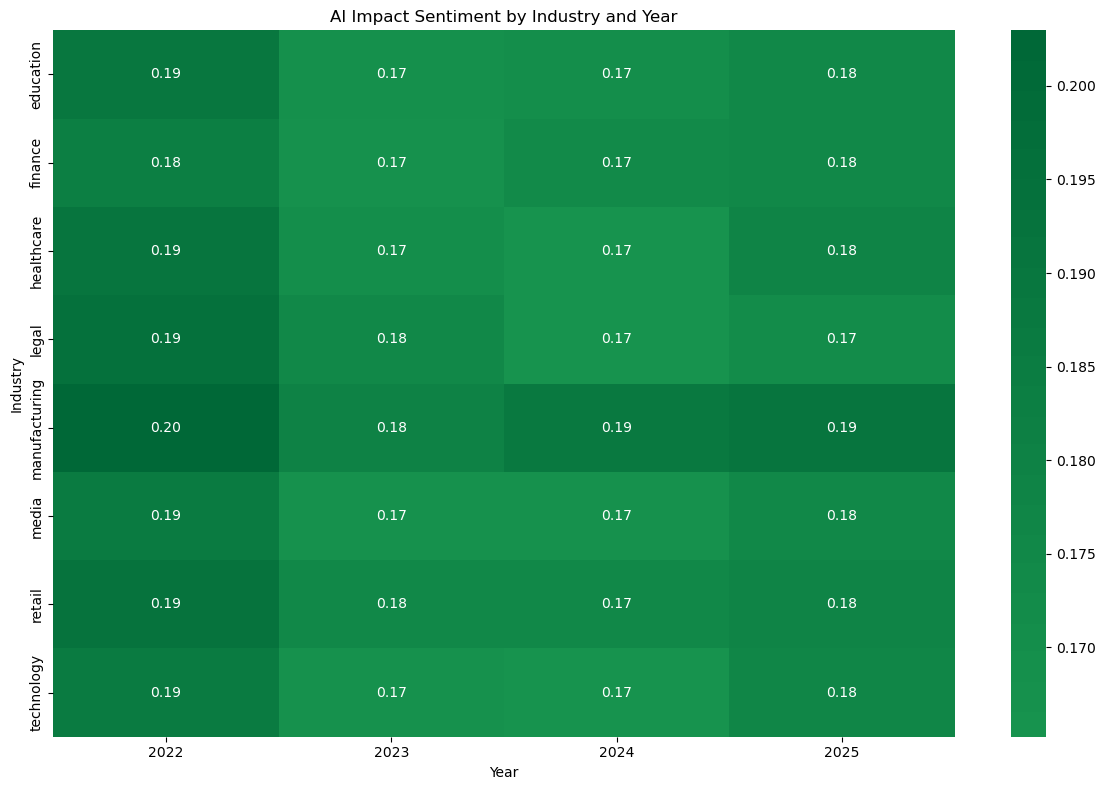

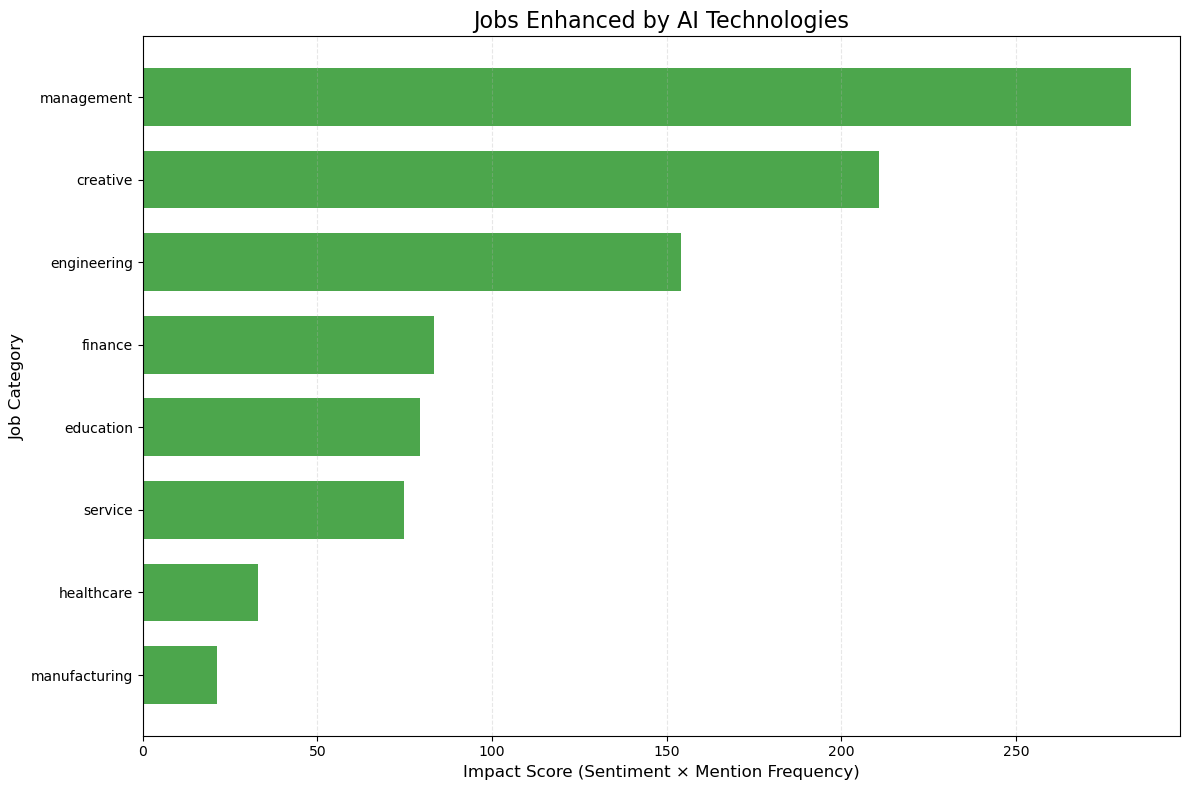

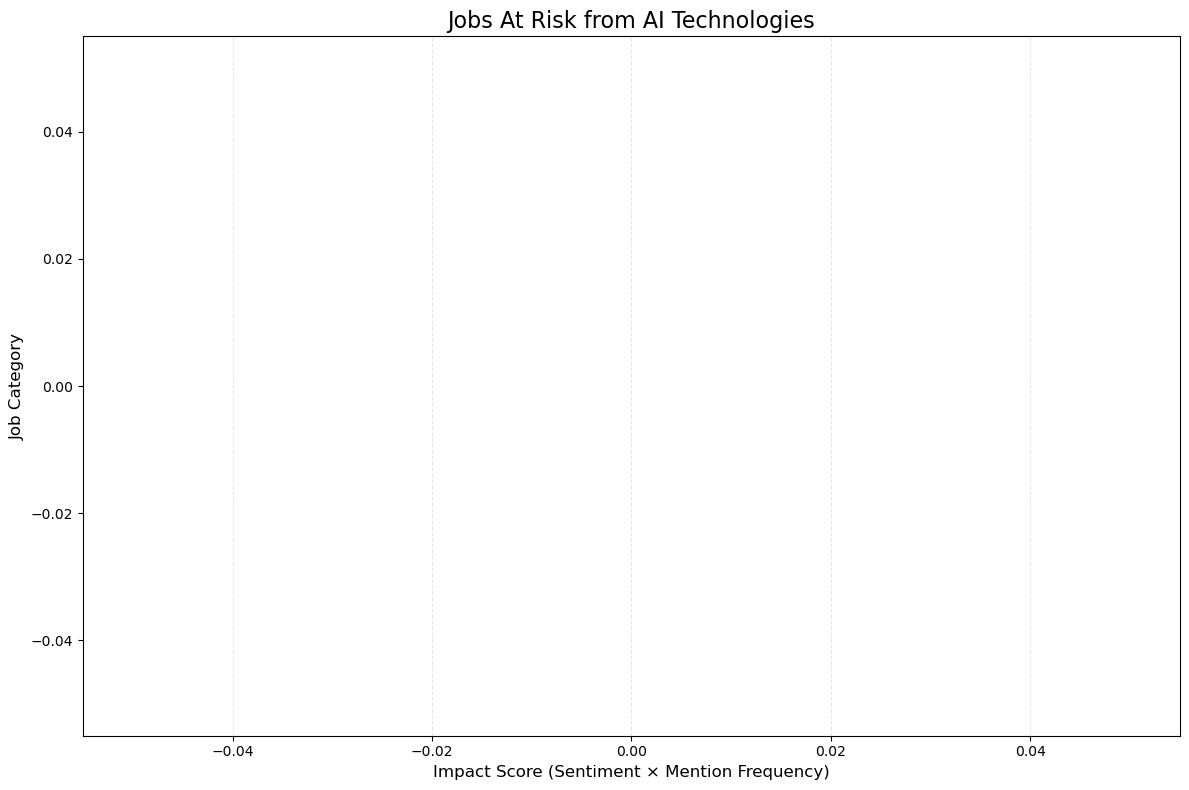

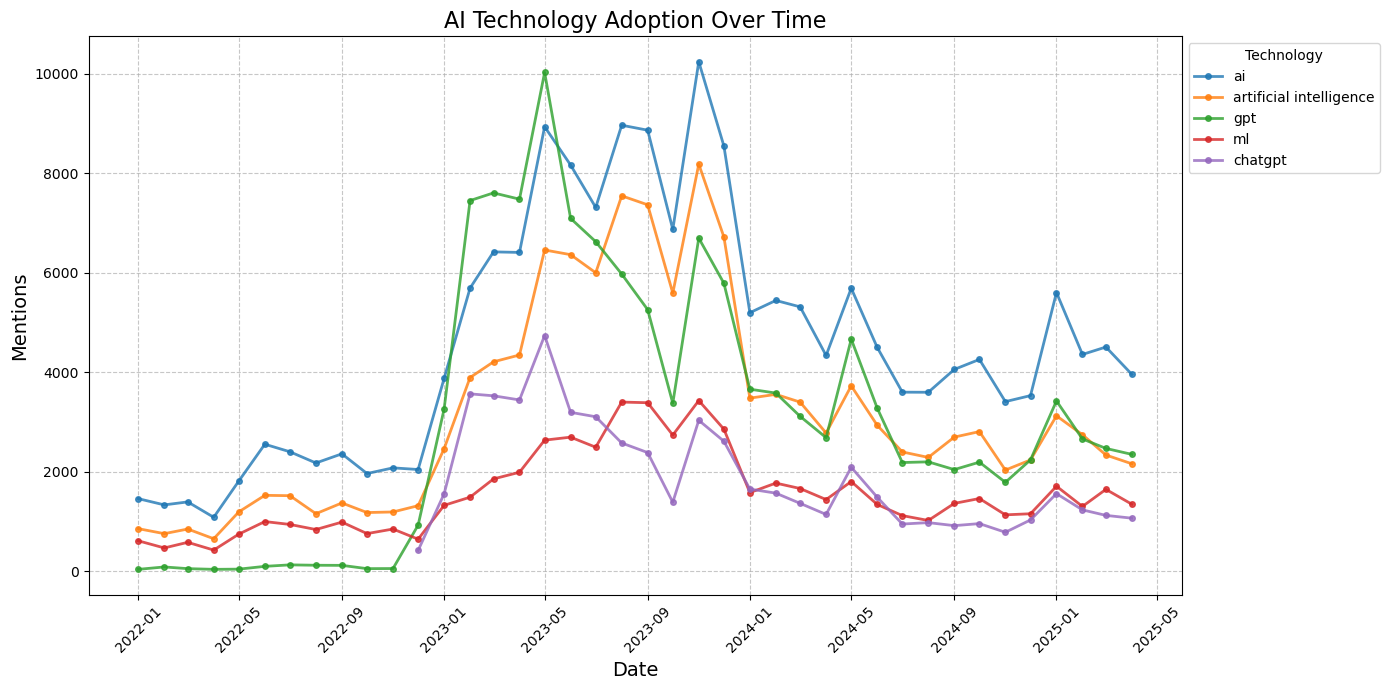

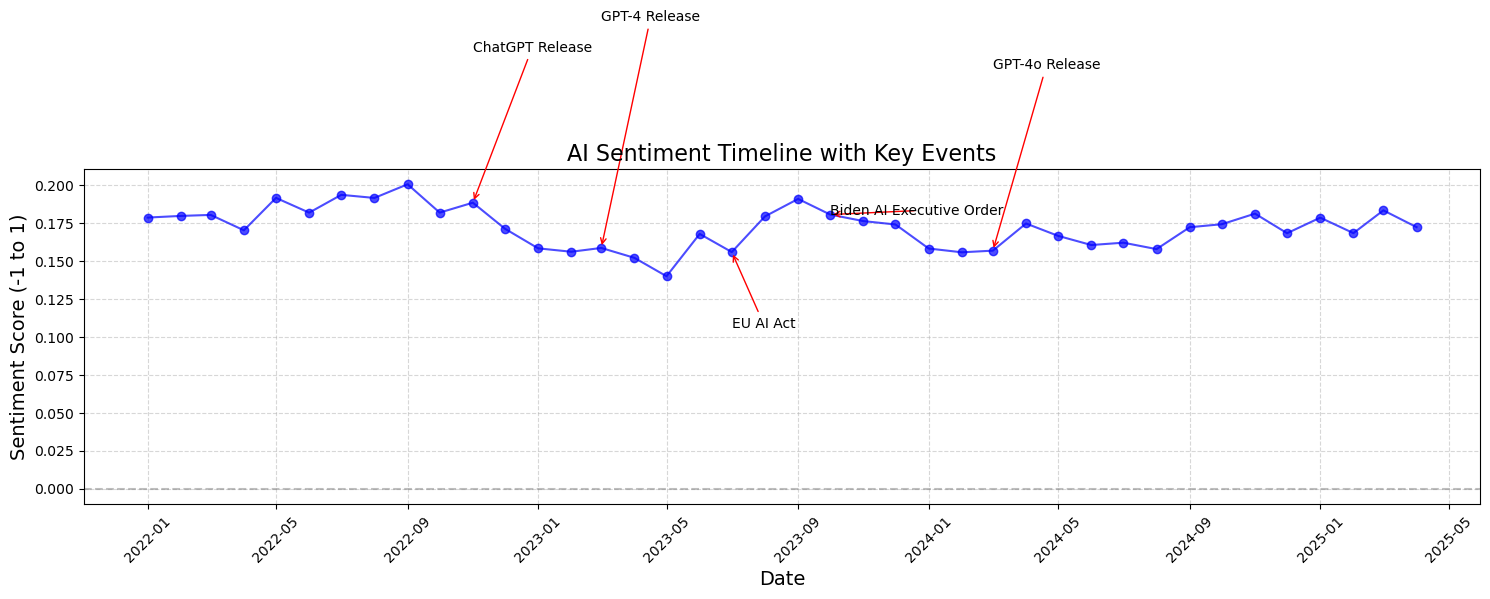

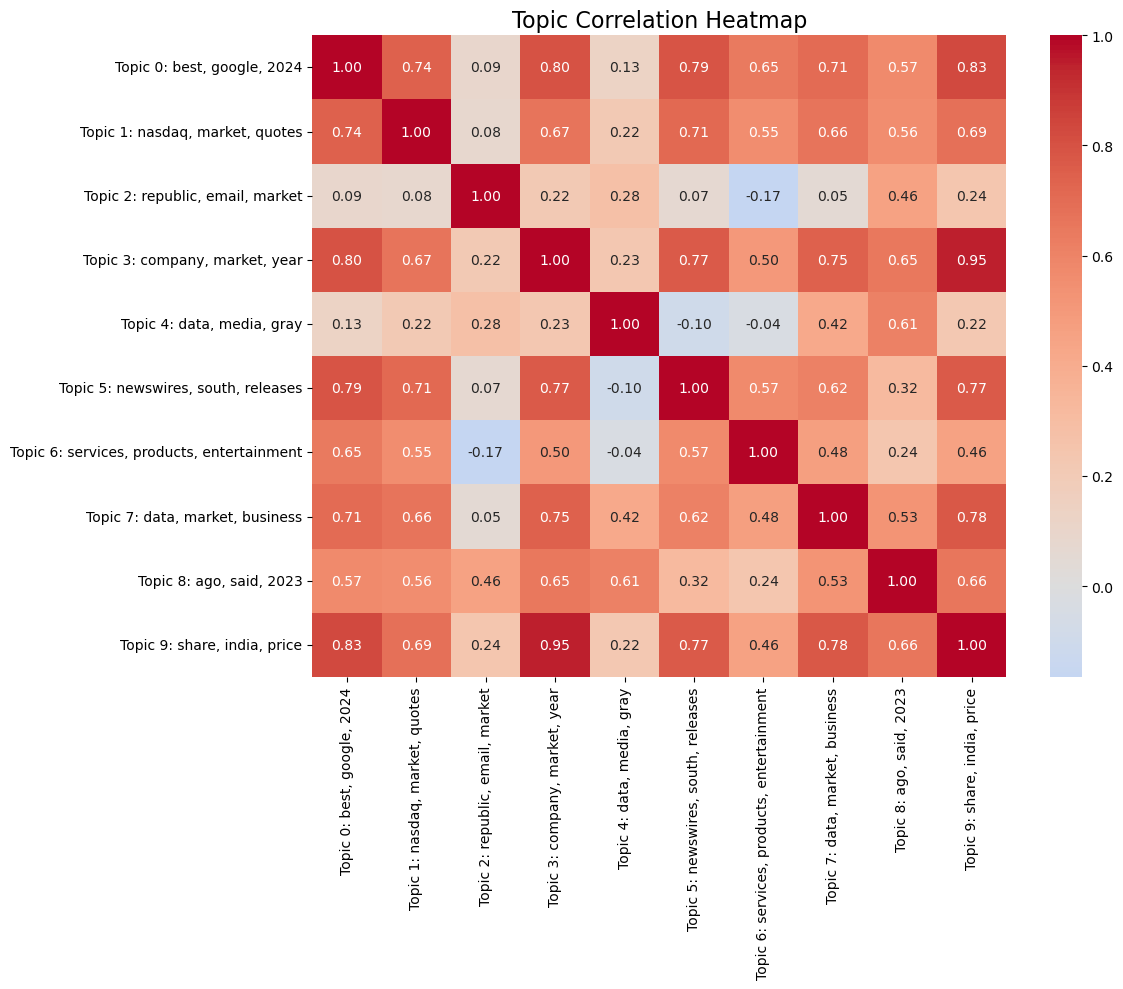

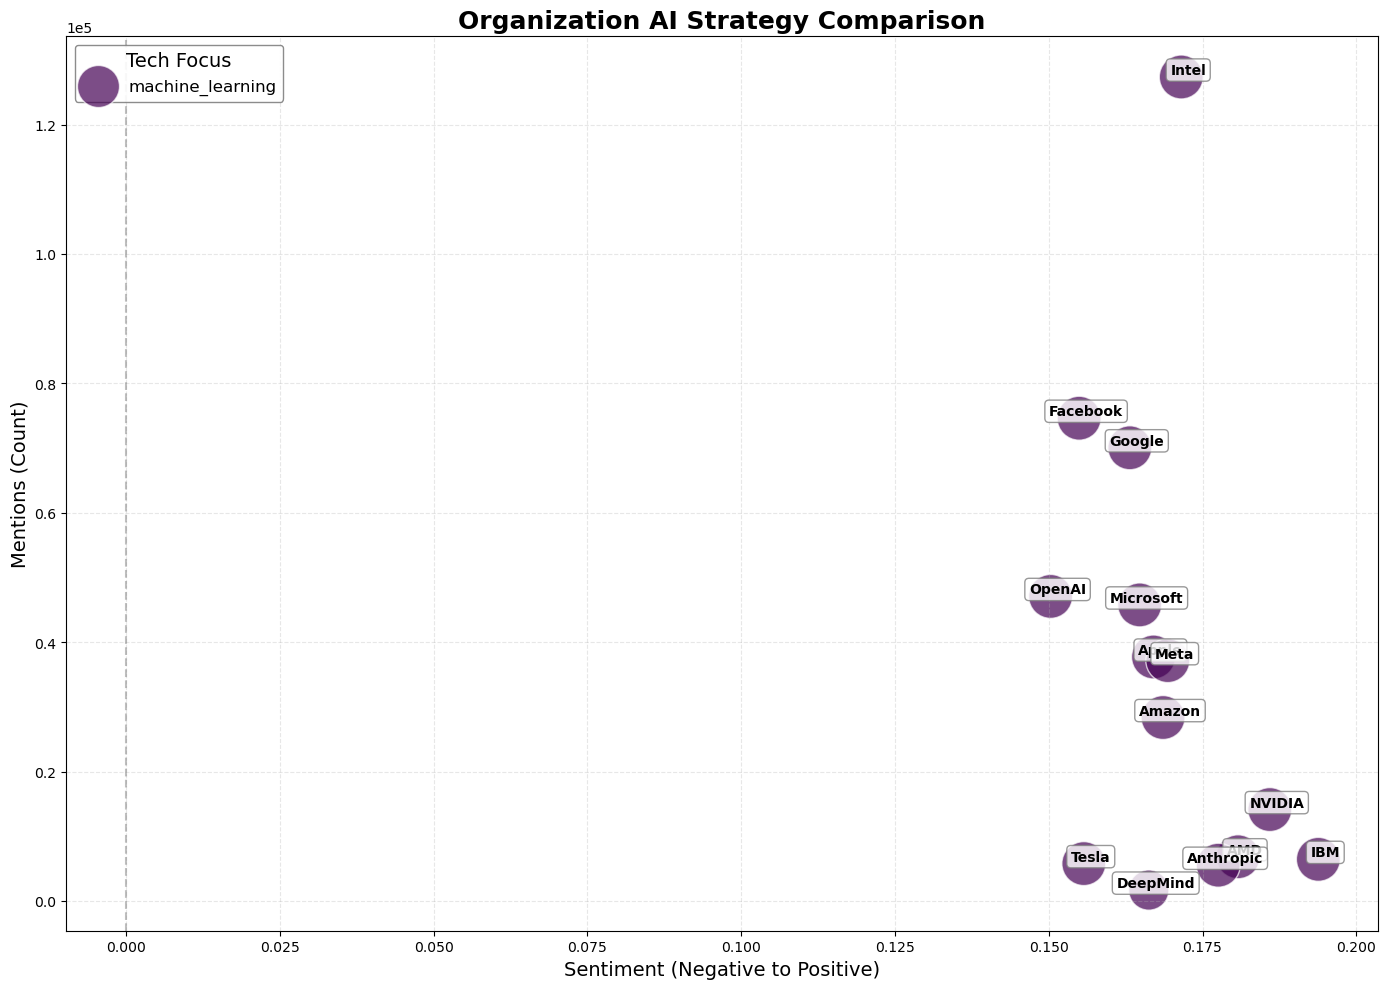

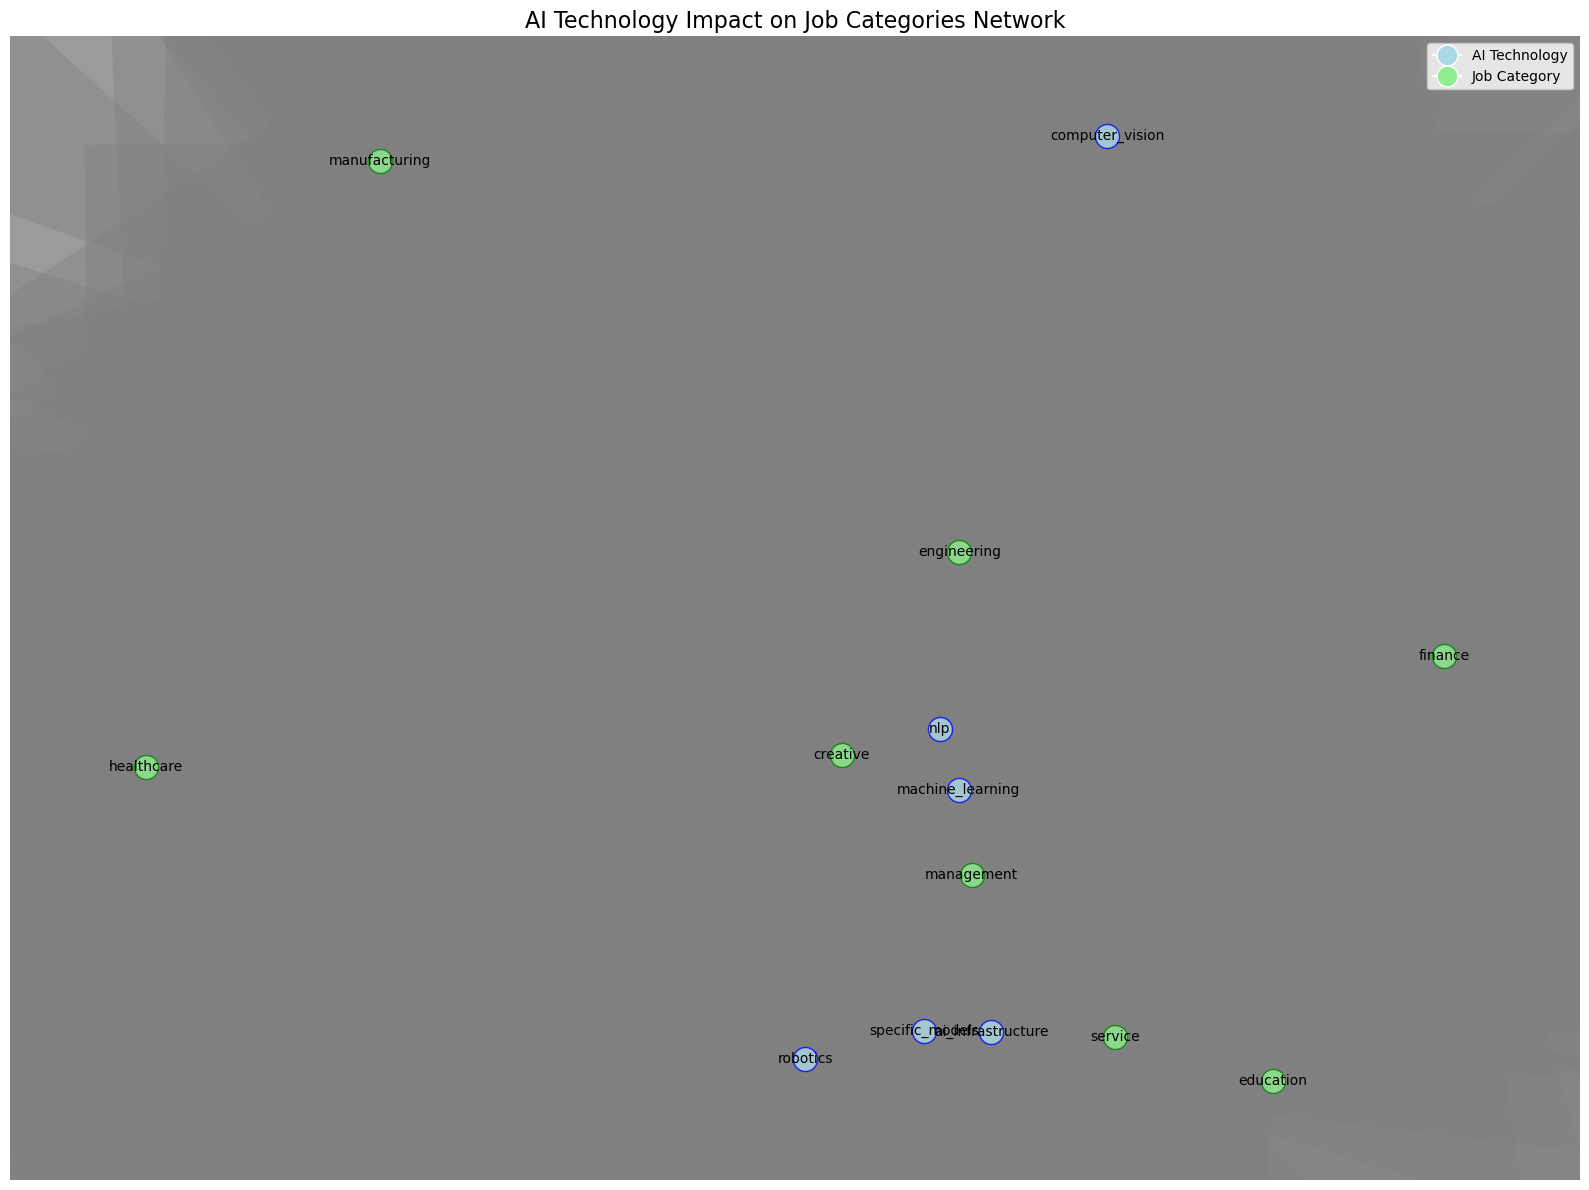

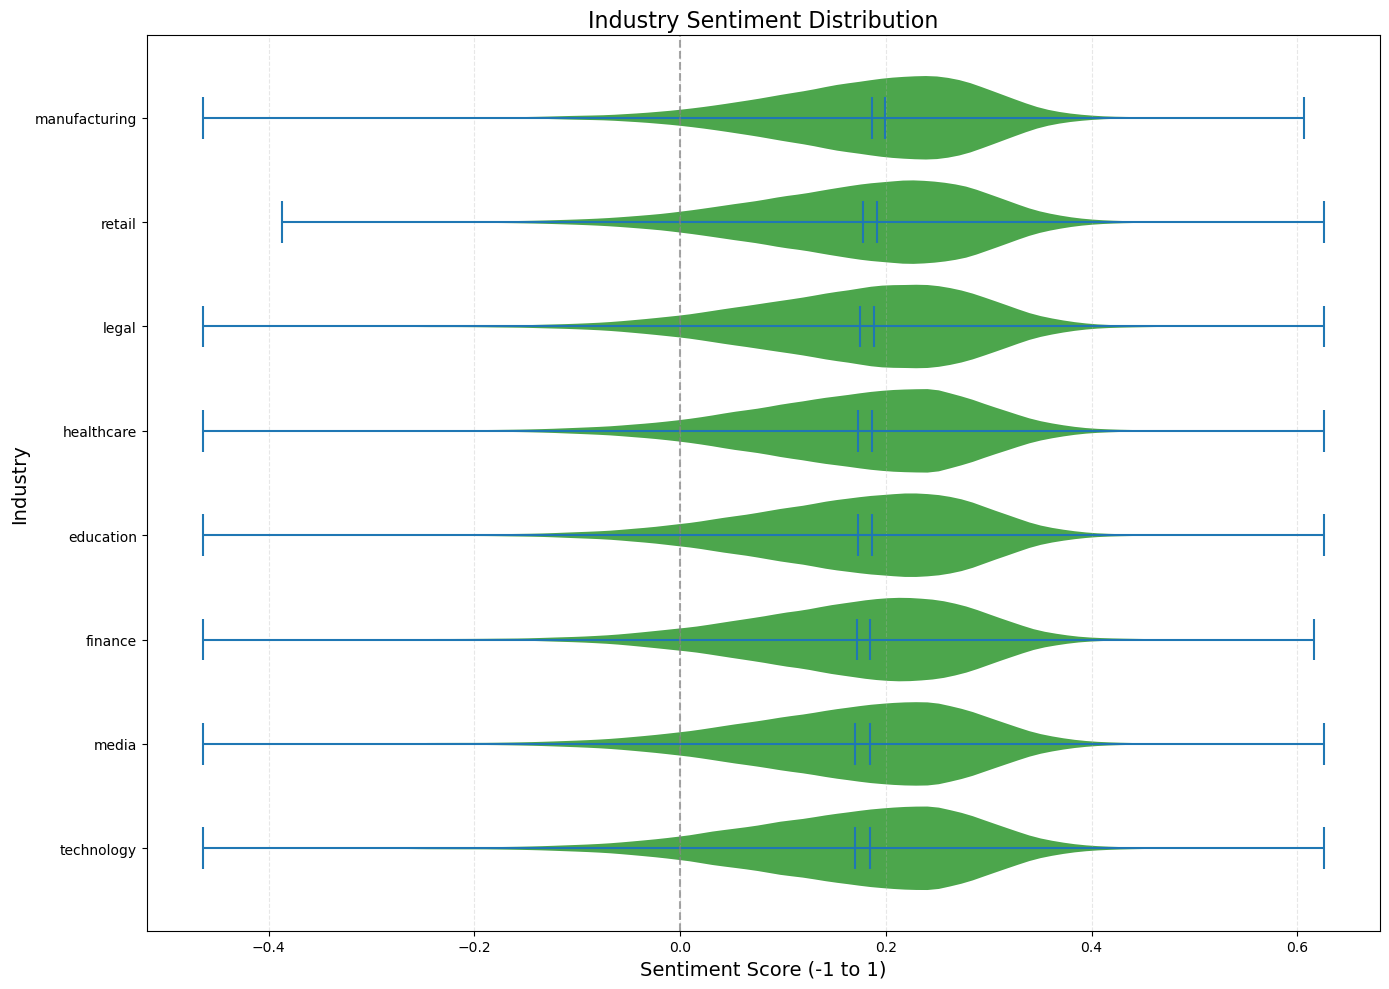

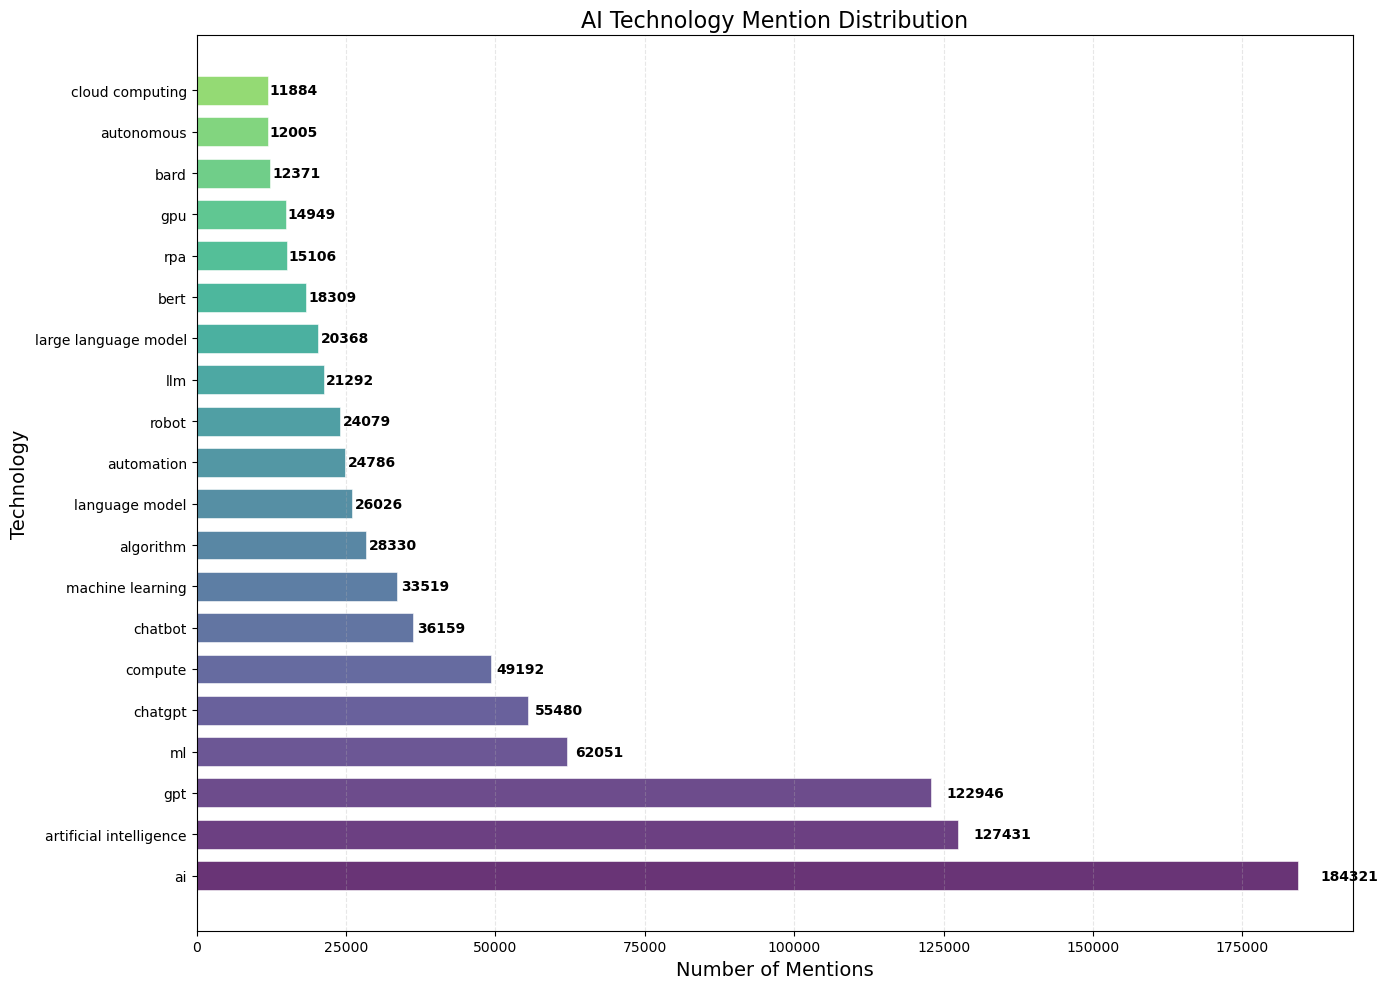

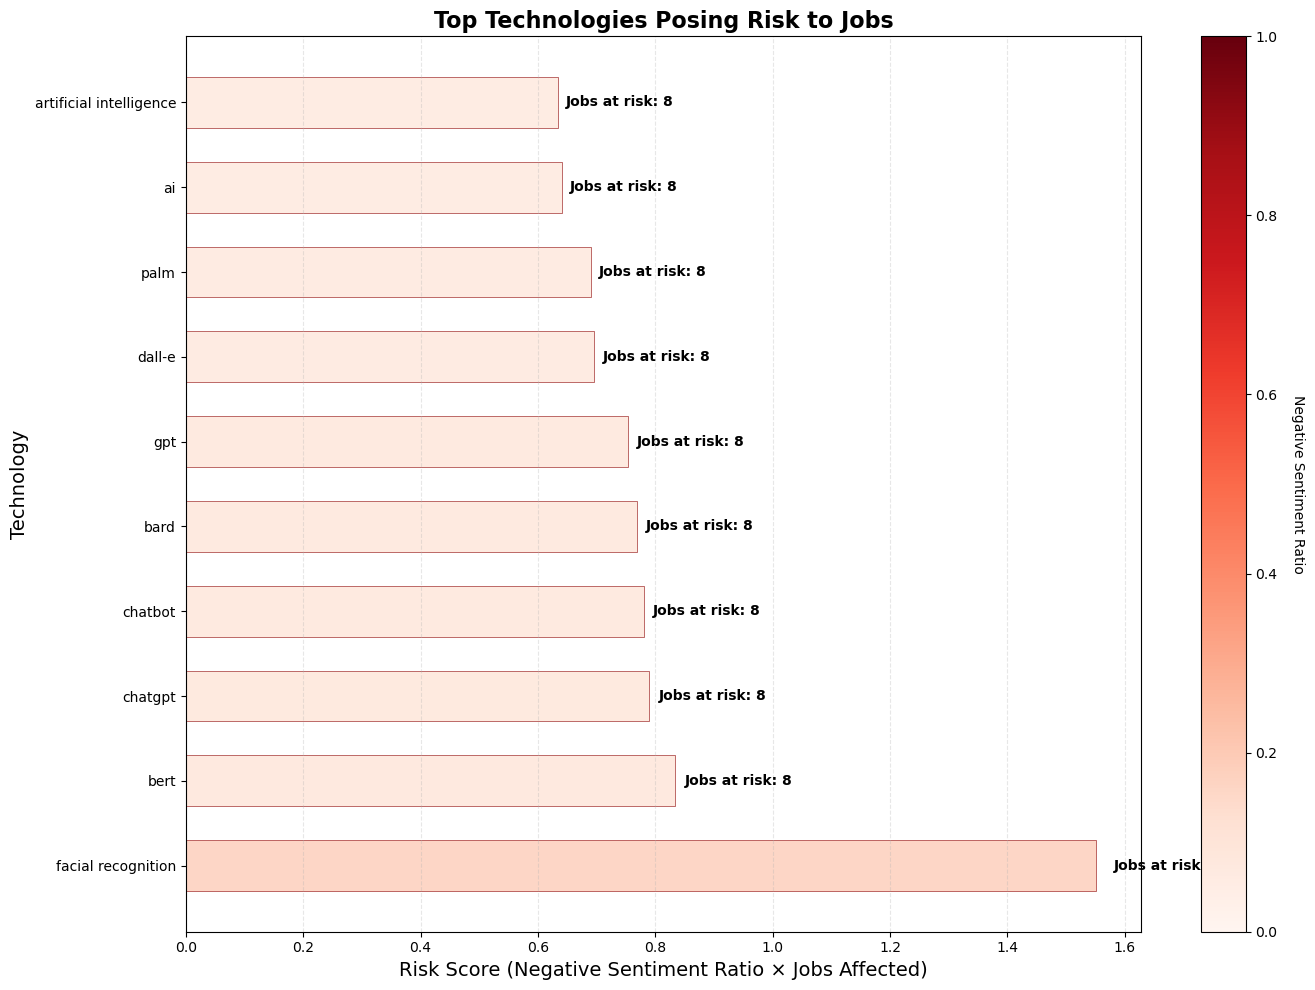

Analyzing industries with jobs at risk...

TOP 10 INDUSTRIES WITH JOBS AT RISK FROM AI
Rank  Industry                       Risk Score   Neg. Mentions   Total Mentions  # Jobs at Risk 
--------------------------------------------------------------------------------
1     media                          0.6442       14515           180245          8              
2     technology                     0.6423       14802           184354          8              
3     education                      0.5904       10787           146171          8              
4     finance                        0.5799       8897            122744          8              
5     healthcare                     0.5794       9336            128916          8              
6     legal                          0.5733       8507            118712          8              
7     retail                         0.5382       8439            125436          8              
8     manufacturing                  0.4014     

/var/folders/4g/7cwxt52n09sb7vzyh6tzj3w00000gn/T/ipykernel_64181/2292401369.py:13: DeprecationWarning: Pickle, copy, and deepcopy support will be removed from itertools in Python 3.14.
  pickle.dump(obj, f)


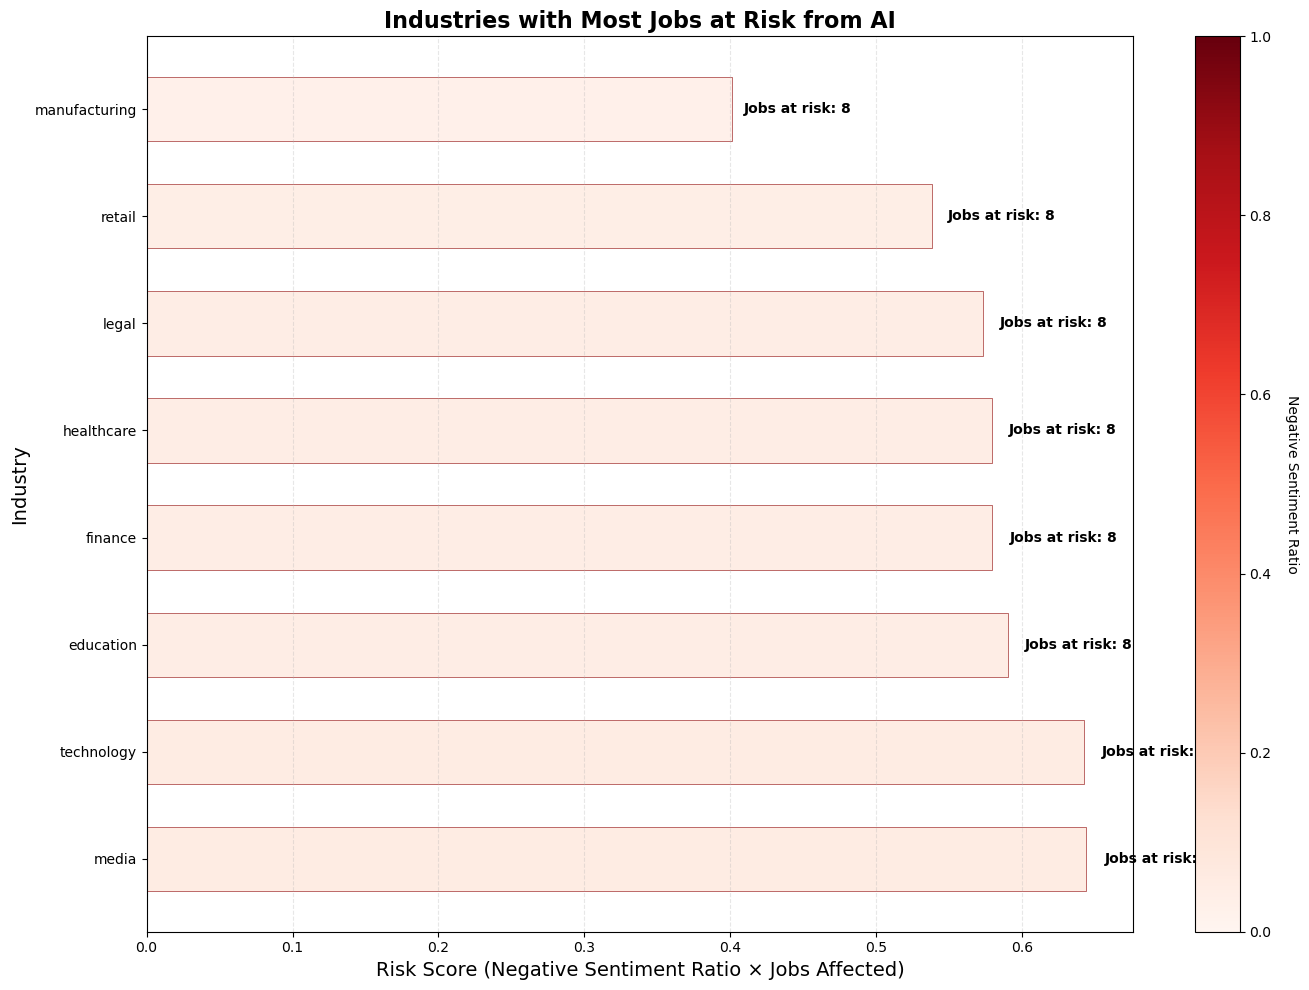

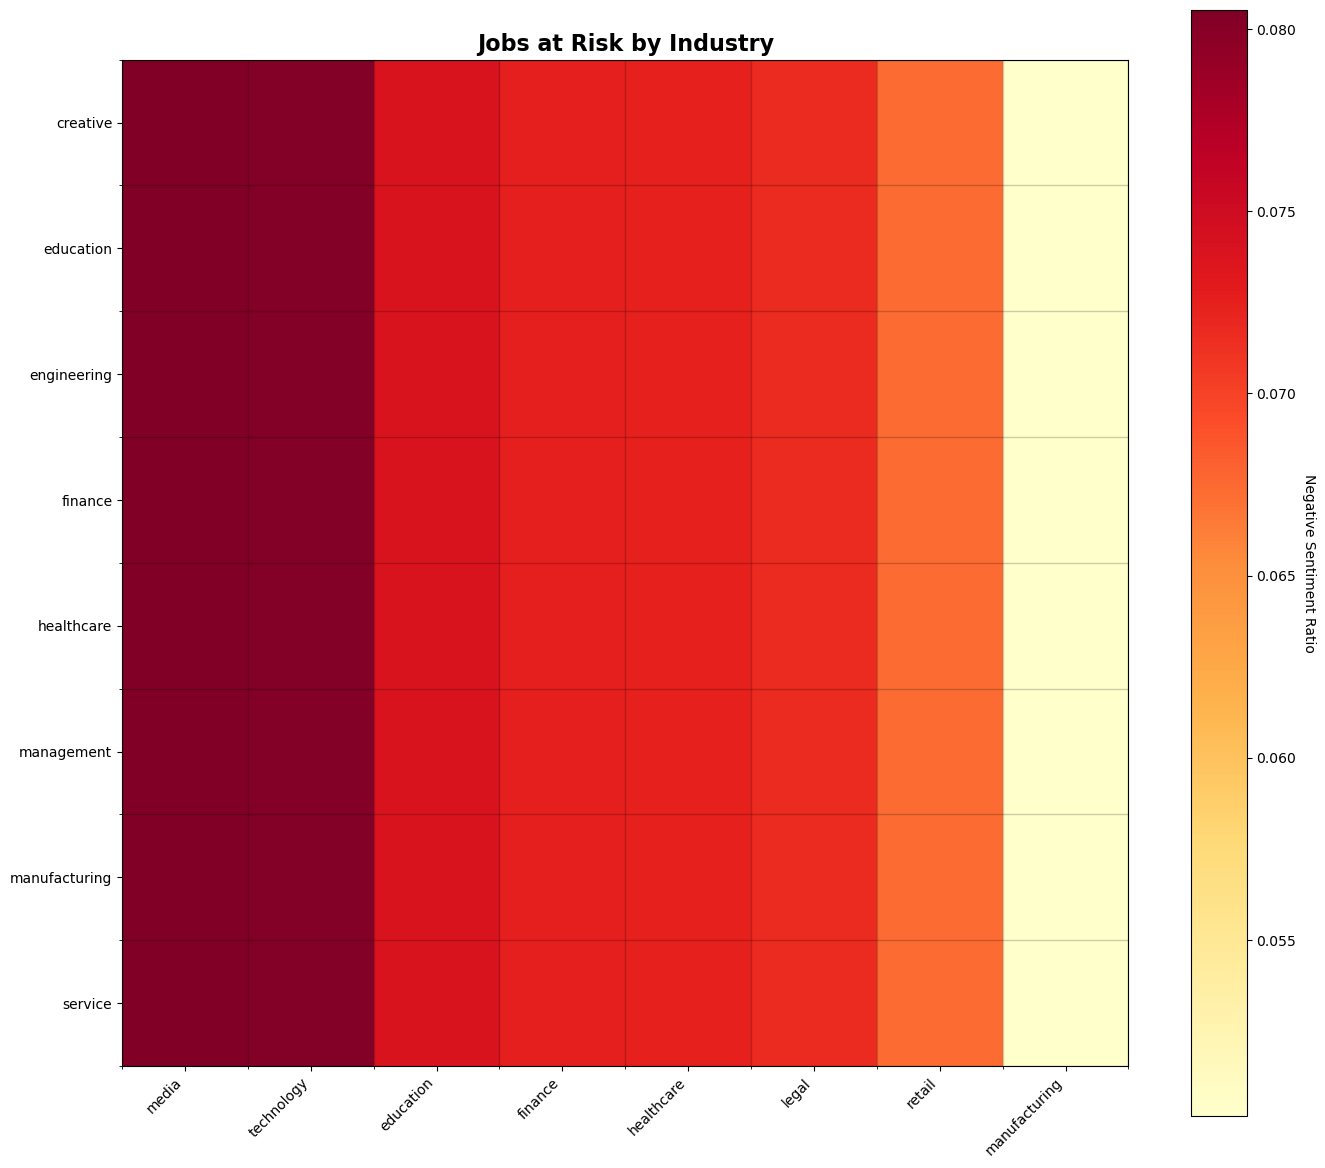

In [7]:
if __name__ == "__main__":
    run_post_lda_analysis()

_1. AI Impact Sentiment by Industry and Year_

Industries vary in being ready and optimism toward AI. Manufacturing and healthcare remain cautious, while tech and media lead adoption.

Manufacturing showed a drop in sentiment in 2023 but rebounded in 2024 and 2025. Where legal, finance and healthcare show consistent neutral to slightly positive scores.

_2. Jobs Enhanced by AI Technologies_

- Management, creative and engineering jobs benefit the most from AI.
- Service, healthcare and manufacturing show lower enhancement scores.

Creative and strategic roles are more positively impacted, while routine roles are less enhanced and potentially at risk.

_3. AI Technology Adoption Over Time_

GPT models marked a peak point in AI visibility and discussion. I can see major spikes for GPT and ChatGPT in early 2023.

_4. Topic Correlation Heatmap_

There's a strong correlation between Topics 0, 3, and 9 which consist of tech, companies and market terms. AI investment is tightly linked to tech, business, and media. Topic 6 is vaguely connected to the others.

_5. AI Sentiment Timeline with Key Events_

The sentiment spikes at GPT-4 and ChatGPT release, it then drops close to regulatory events like the EU AI Act. This shows that the public perception of AI is event driven. It can be interpreted that rollouts create optimism, while regulation prompt concern.

_6. Organization AI Strategy Comparison_

OpenAI, Microsoft, Meta and NVIDIA are highly mentioned and positively viewed. Tesla and IBM have a lower sentiment but are still key players. The positive sentiment clusters around big AI leaders.

_7. AI Technology Impact on Job Categories_

Machine learning and NLP are strongly tied to creative, management and engineering roles. Robotics is linked to manufacturing and service jobs. NLP enhances knowledge work, while robotics affects physical labor sectors.

_8. Industry Sentiment Distribution_

Technology, media and finance have a narrow and high score sentiment distributions.
Industries like media are more confident and stable in AI adoption.
While, healthcare and legal have a wide and mixed sentiment distributions Healthcare and legal sectors reflect uncertainty or ethical issues.

_9. AI Technology Mention Distribution_

NLP technologies are the most publicly visible, signaling where innovation is concentrated that's why AI, GPT and ChatGPT dominate.

_10. Top Technologies Posing Risk to Jobs_

I calculated the risk score for each industry by multiplying:
The number of job categories affected × the negative sentiment ratio in the articles where that industry was mentioned.

I calculated the number of jobs affected by the counts of how many different kinds of jobs are perceived to be at risk from AI in a given industry, based on negative mentions in the dataset. If the job was repeated I only counted it once.

Jobs Affected = len(set(jobs_with_negative_mentions_per_industry))

This helped quantify which industries face the greatest risk from AI disruption.Media and Technology industries show the highest perceived job displacement risks from AI, especially in content creation and programming sectors.